In [41]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Questions we are trying to answer:

- Does changing the initial sampling scheme accelerate the function optimization?
- How well does each initial sampling scheme identify important dimensions?
- How quickly does the posterior concentrate?
- Comparing different sampling schemes: random vs. dyadic -- how often do the perturbed dimensions actually include an important dimension (from an oracle point of view)

can we calculate the entropy on which dimensions are important from the empirical posterior samples?

- in theory, the NUTS sampling produces a collection of length scales for each dimensions
- right now I'm just logging the median
- but, for each dimensions, can also extract the fraction of samples where it's large (i.e., unimportant)
- or the average ranking of each dimensions among all 50
- this will help with calculating the entropy? TODO: derive math expression

In [42]:
def get_lengthscale_stats(l, n_top = 6, thres = 0.1):
    quantile = []
    count_below_threshold = []
    var = []

    for i in range(l.shape[0]):
        quantile.append(sorted(l[i])[n_top-1])
        count_below_threshold.append(sum(l[i]<thres))
        var.append(np.var(l[i]))
    
    return quantile, count_below_threshold, var

In [59]:
# seeds 21, 24, 25 are giving super large length scales (hundreds), weird
l = np.load('/home/yz685/saasbo/results/hartmann6_50/median_lengthscales/median_lengthscales_' \
            + '00_02_23' + '.npy')

In [60]:
l.shape

(29, 50)

In [61]:
q, c, v = get_lengthscale_stats(l, thres = 1)

(array([ 3.,  0.,  8., 12., 11.,  9.,  5.,  1.,  0.,  1.]),
 array([0.28041919, 0.82767311, 1.37492703, 1.92218095, 2.46943487,
        3.01668879, 3.56394271, 4.11119663, 4.65845055, 5.20570447,
        5.75295839]),
 <BarContainer object of 10 artists>)

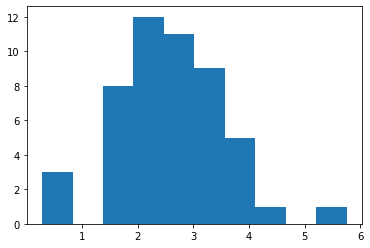

In [62]:
plt.hist(l[-1])

In [74]:
Y_dict = {}
Q_dict = defaultdict(list)
C_dict = defaultdict(list)

frac_perturb_samples_list = [0.0, 0.8]
frac_perturb_dims_list = [0.1, 0.2, 0.5]

perturb_configs = [(f1, f2) for f1 in frac_perturb_samples_list for f2 in frac_perturb_dims_list]

# trials = [21, 22, 23, 24, 25]
trials = [11, 12, 13, 14, 15]
n_trials = len(trials)

In [41]:
y = np.load('/home/yz685/saasbo/results/hartmann6_50/median_lengthscales/median_lengthscales_' \
            + '10' + '_' + '01'  + '_' + '25' + '.npy')
y

array([[3.94539095e+02, 2.99209678e-01, 4.15824057e+02, ...,
        1.79980179e+02, 2.42473658e+02, 3.29189049e+02],
       [3.34271308e+02, 3.97509606e-01, 1.71581759e+02, ...,
        3.23723431e-01, 2.87650715e+02, 1.69685858e+02],
       [3.13547216e+02, 2.94164599e+02, 1.49180641e+02, ...,
        2.72799218e-01, 2.14588065e+02, 3.74001020e+02],
       ...,
       [1.67467528e+02, 3.45217472e+02, 3.27602999e+02, ...,
        5.44482000e-01, 2.30256946e+02, 1.77136503e+02],
       [2.53772149e+02, 1.21272305e-01, 3.23068180e+02, ...,
        1.14784601e-01, 3.08653535e+02, 2.64571807e+02],
       [2.58988615e+02, 2.56180829e+02, 3.69878560e+02, ...,
        4.00966251e-01, 2.72207005e+02, 2.00087995e-02]])

In [75]:
for frac_perturb_samples_num, frac_perturb_dims_num in perturb_configs:

    frac_perturb_samples = str(frac_perturb_samples_num).replace('.', '')
    frac_perturb_dims = str(frac_perturb_dims_num).replace('.', '')

    Y = None
    Q = None
    C = None
    V = None
    for trial in trials:
        y = np.load('/home/yz685/saasbo/results/hartmann6_50/output_at_X/output_at_X_' \
            + frac_perturb_samples + '_' + frac_perturb_dims  + '_' + str(trial) + '.npy')
        y = np.expand_dims(np.minimum.accumulate(y), 0)
        if Y is None:
            Y = y 
        else:
            Y = np.vstack((Y, y))
        
        ell_median = np.load('/home/yz685/saasbo/results/hartmann6_50/median_lengthscales/median_lengthscales_' \
            + frac_perturb_samples + '_' + frac_perturb_dims  + '_' + str(trial) + '.npy')
        
        if len(ell_median.shape) > 1:        
            q, c, v = get_lengthscale_stats(ell_median, thres = 1)

            Q_dict[(frac_perturb_samples_num, frac_perturb_dims_num)].append(q)
            C_dict[(frac_perturb_samples_num, frac_perturb_dims_num)].append(c)
   

    
    Y_dict[(frac_perturb_samples_num, frac_perturb_dims_num)] = Y



    for i in ell_median[-1].argsort()[:6]:
        if i not in [1, 7, 11, 23, 47, 33]:
            print(f'Failed to identify important dimension {i} at {frac_perturb_samples_num} samples perturbed, {frac_perturb_dims_num} dimensions perturbed, trial {trial}')
            # print(f"Parameter {i:2} Median lengthscale = {ell_median[i]:.2e}")

Failed to identify important dimension 0 at 0.0 samples perturbed, 0.1 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.0 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.0 samples perturbed, 0.5 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.8 samples perturbed, 0.1 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.8 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.8 samples perturbed, 0.5 dimensions perturbed, trial 15


In [105]:
test = [1,2,3,4,5]
k = [1,3, 6]

In [107]:
len(set(test).intersection(set(k)))

2

frac_pert_samples 0.0, frac_pert_dims 0.1, final value -2.9186004722734453
frac_pert_samples 0.0, frac_pert_dims 0.2, final value -2.95998516831239
frac_pert_samples 0.0, frac_pert_dims 0.5, final value -2.9434186414857724
frac_pert_samples 0.8, frac_pert_dims 0.1, final value -2.7279317260826006
frac_pert_samples 0.8, frac_pert_dims 0.2, final value -3.1604601695138035
frac_pert_samples 0.8, frac_pert_dims 0.5, final value -2.9863904697722643


Text(0.5, 1.0, 'Hartmann6 (d=6, D=50)')

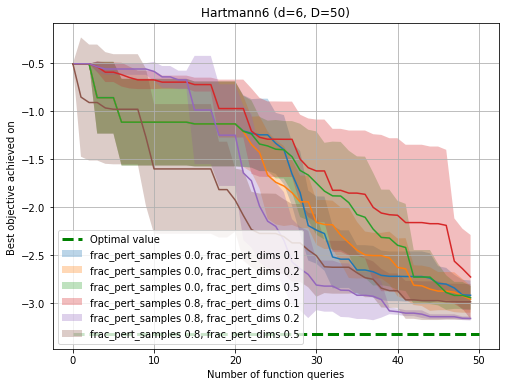

In [78]:
n_iters = 50

plt.figure(figsize=(8,6))
plt.plot([0, 50], [-3.322, -3.322], "--", c="g", lw=3, label="Optimal value")
plt.grid(True)

for frac_perturb_samples_num, frac_perturb_dims_num in Y_dict.keys():

    Y = Y_dict[(frac_perturb_samples_num, frac_perturb_dims_num)][:, :n_iters]

    Y_mean = np.mean(Y, axis = 0)

    plt.plot(Y_mean)
    plt.fill_between(
        np.arange(len(Y[0])),
        Y_mean - 2 * np.std(Y, axis=0) / (n_trials ** 0.5),
        Y_mean + 2 * np.std(Y, axis=0) / (n_trials ** 0.5),
        alpha = 0.3, label = 'frac_pert_samples {}, frac_pert_dims {}'.format(frac_perturb_samples_num, frac_perturb_dims_num)
    )

    print('frac_pert_samples {}, frac_pert_dims {}, final value {}'.format(frac_perturb_samples_num, frac_perturb_dims_num, Y_mean[-1]))

plt.legend()
plt.xlabel('Number of function queries') # seems liike I'm not including the initial ones
plt.ylabel('Best objective achieved on ')
plt.title('Hartmann6 (d=6, D=50)')

frac_pert_samples 0.0, frac_pert_dims 0.1, final value -1.9986854027171599
frac_pert_samples 0.0, frac_pert_dims 0.2, final value -1.9986854027171599
frac_pert_samples 0.0, frac_pert_dims 0.5, final value -1.9986854027171599
frac_pert_samples 1.0, frac_pert_dims 0.1, final value -1.9986854027171599
frac_pert_samples 1.0, frac_pert_dims 0.2, final value -1.9986854027171599
frac_pert_samples 1.0, frac_pert_dims 0.5, final value -1.9986854027171599


Text(0.5, 1.0, 'Hartmann6 (d=6, D=50)')

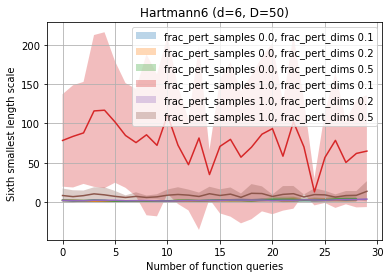

In [40]:
#plt.plot([0, 30], [-3.322, -3.322], "--", c="g", lw=3, label="Optimal value")
plt.grid(True)

for frac_perturb_samples_num, frac_perturb_dims_num in Q_dict.keys():

    if frac_perturb_samples_num == 0.8 and frac_perturb_dims_num == 0.1:
        continue

    Q = Q_dict[(frac_perturb_samples_num, frac_perturb_dims_num)]

    Q_mean = np.mean(Q, axis = 0)

    plt.plot(Q_mean)
    plt.fill_between(
        np.arange(len(Q[0])),
        Q_mean - 2 * np.std(Q, axis=0) / (n_trials ** 0.5),
        Q_mean + 2 * np.std(Q, axis=0) / (n_trials ** 0.5),
        alpha = 0.3, label = 'frac_pert_samples {}, frac_pert_dims {}'.format(frac_perturb_samples_num, frac_perturb_dims_num)
    )

    print('frac_pert_samples {}, frac_pert_dims {}, final value {}'.format(frac_perturb_samples_num, frac_perturb_dims_num, Y_mean[-1]))

plt.legend()
plt.xlabel('Number of function queries') # seems liike I'm not including the initial ones
plt.ylabel('Sixth smallest length scale ')
plt.title('Hartmann6 (d=6, D=50)')